## Gaussian mixture example

In [67]:
# Load packages
options(warn = -1)
library(MASS)
library(mnormt)
library(class)
library(dplyr)
library(ggplot2)
options(repr.plot.width=10, repr.plot.height=8)

We simulate the Gaussian mixture

In [68]:
set.seed(1)
n =200
p = 1/2
n1 = p*n
n2 = (1-p)*n

In [69]:
mu1 = c(0,0)
mu2 = c(0,0)
M = matrix(
  rbind(c(0,1),c(1,0),c(0,1)/2,c(1,0)/3), ncol = 2
)

In [70]:
mu1 = c(0,0)
mu2 = c(0,2)
M = matrix(
  rbind(c(1,1),c(1,0),c(0,1),c(-1,-0.5)), ncol = 2
)

In [71]:
Sigma1 = M[1:2,] %*% t(M[1:2,])
Sigma2 = M[3:4,] %*% t(M[3:4,])
X1 = mvrnorm(n1, mu1, Sigma1)
X2 = mvrnorm(n2, mu2, Sigma2)
X = rbind(X1, X2)
Y = c(rep(0,n1),rep(1,n2))

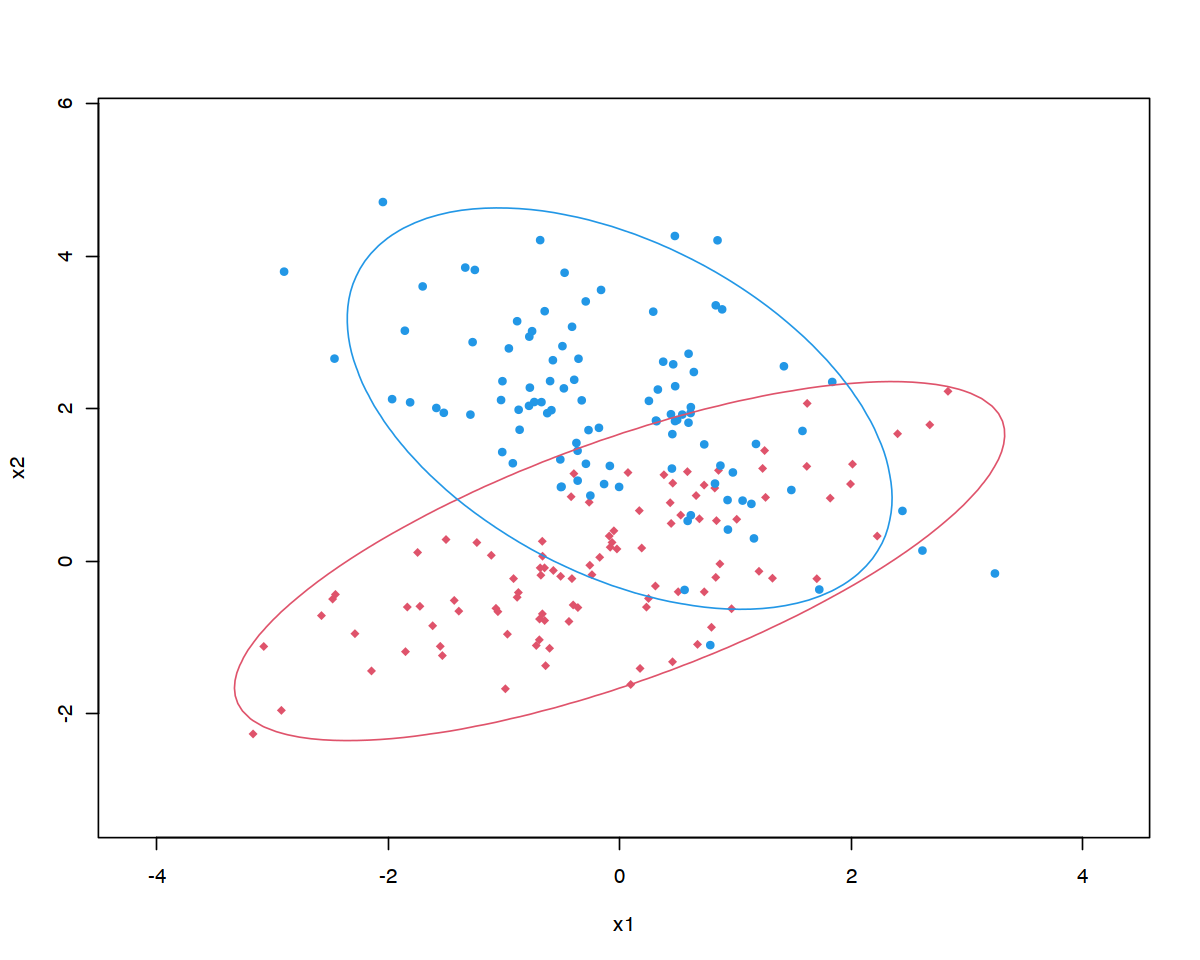

In [72]:
xmin = min(X[,1])-1
xmax = max(X[,1])+1
ymin = min(X[,2])-1
ymax = max(X[,2])+1
a <- seq(xmin,xmax , 0.1)
b <- seq(ymin, ymax, 0.1)
f1 <- function(a, b) dmnorm(cbind(a, b), mu1, Sigma1)
f2 <- function(a, b) dmnorm(cbind(a, b), mu2, Sigma2)

y1 <- outer(a, b, f1)
y2 <- outer(a, b, f2)

# create contour plot
plot(X, col = 2*Y+2, pch=2*Y+18, xlab = "x1", ylab="x2", xlim = c(xmin,xmax), ylim = c(ymin,ymax))
contour(a, b, y1,levels = 0.01, col = 2, add = TRUE, drawlabels = FALSE)
contour(a,b, y2, levels = 0.01, add = TRUE, col = 4, drawlabels = FALSE)

### Logistic model

In [73]:
train.data <- data.frame(cbind(X, X^2, X[,1]*X[,2]), Y)
model <- glm(Y ~., data = train.data, family = binomial)
test.grid <- expand.grid(x=seq(min(X[,1]-1), max(X[,1]+1),
                          by=0.1),
                    y=seq(min(X[,2]-1), max(X[,2]+1), 
                          by=0.1))
train.data$Y <- as.factor(train.data$Y)
test.data <- data.frame(cbind(test.grid, test.grid^2, test.grid[,1]*test.grid[,2]))
names(test.data) = names(train.data[1:ncol(test.data)])
  
result <- predict(model, test.data)
classif <- factor(as.numeric(result > 0))
prob <- 1/(1+exp(-result))
prob <- pmax(prob, 1-prob)

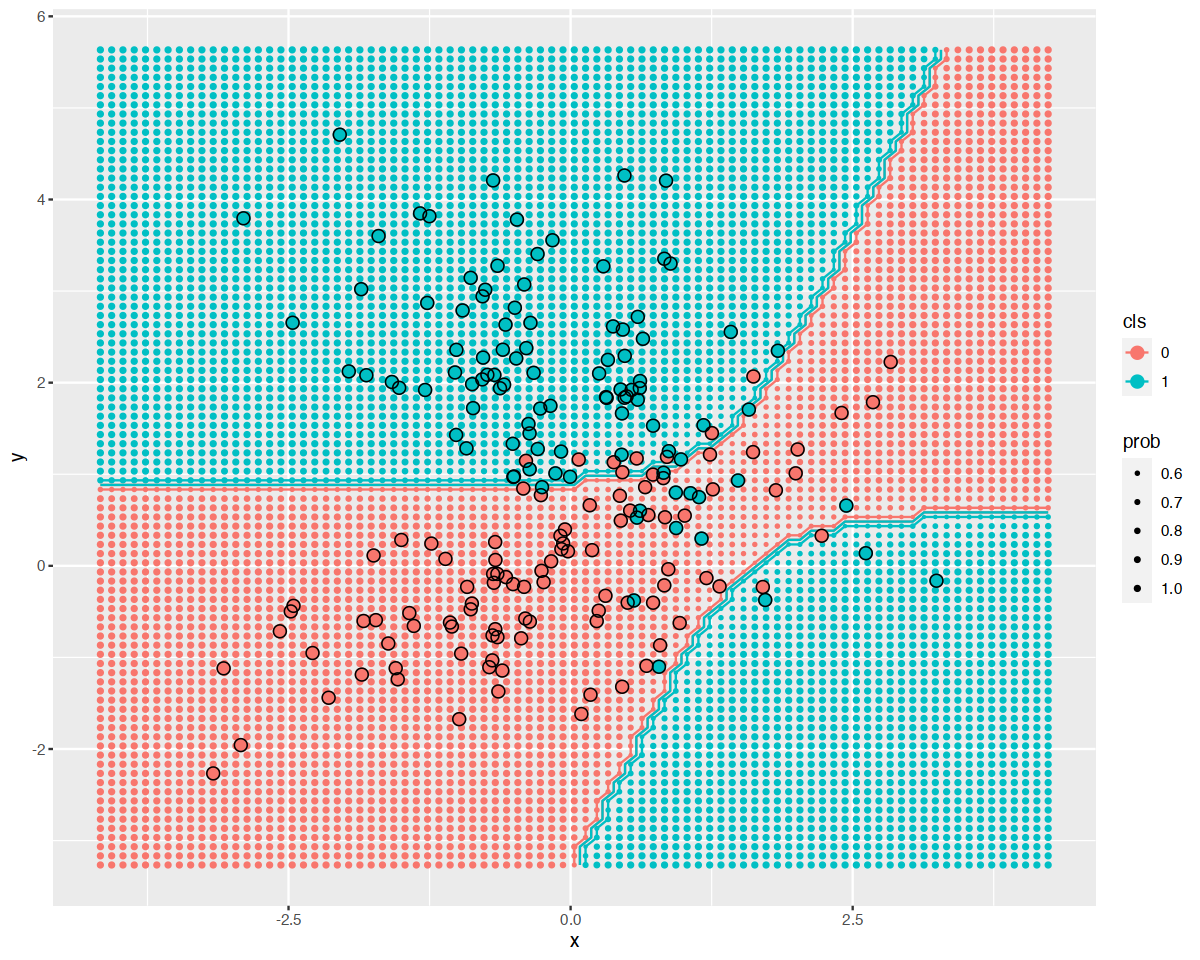

In [74]:
dataf <- bind_rows(mutate(test.grid,
                          prob=prob,
                          cls="1",
                          prob_cls=ifelse(classif==cls,
                                          1, 0)),
                   mutate(test.grid,
                          prob=prob,
                          cls="0",
                          prob_cls=ifelse(classif==cls,
                                          1, 0)))


ggplot(dataf) + 
  geom_point(aes(x=x, y=y, col=cls, size=prob),
             data = mutate(test.grid, cls=classif)) + 
  scale_size(range=c(0.1, 1)) +
  geom_contour(aes(x=x, y=y, z=prob_cls, group=cls, color=cls),
               bins=2,
               data=dataf) + geom_point(aes(x=x, y=y, col=cls),
             size=3,
             data=data.frame(x=train.data[,1], y=train.data[,2], cls=train.data$Y))  + 
  geom_point(aes(x=x, y=y),
             size=3, shape=1,
             data=data.frame(x=train.data[,1], y=train.data[,2], cls=train.data$Y))

More features?

In [75]:
train.data <- data.frame(cbind(X, X^2, X[,1]*X[,2], X^3, X^4, X^5, X^6, X^7, X^8), Y)
model <- glm(Y ~., data = train.data, family = binomial)
test.grid <- expand.grid(x=seq(min(X[,1]-1), max(X[,1]+1),
                          by=0.1),
                    y=seq(min(X[,2]-1), max(X[,2]+1), 
                          by=0.1))
train.data$Y <- as.factor(train.data$Y)
test.data <- data.frame(cbind(test.grid, test.grid^2, test.grid[,1]*test.grid[,2],test.grid^3,test.grid^4,test.grid^5,test.grid^6,test.grid^7,test.grid^8))
names(test.data) = names(train.data[1:ncol(test.data)])
  
result <- predict(model, test.data)
classif <- factor(as.numeric(result > 0))
prob <- 1/(1+exp(-result))
prob <- pmax(prob, 1-prob)

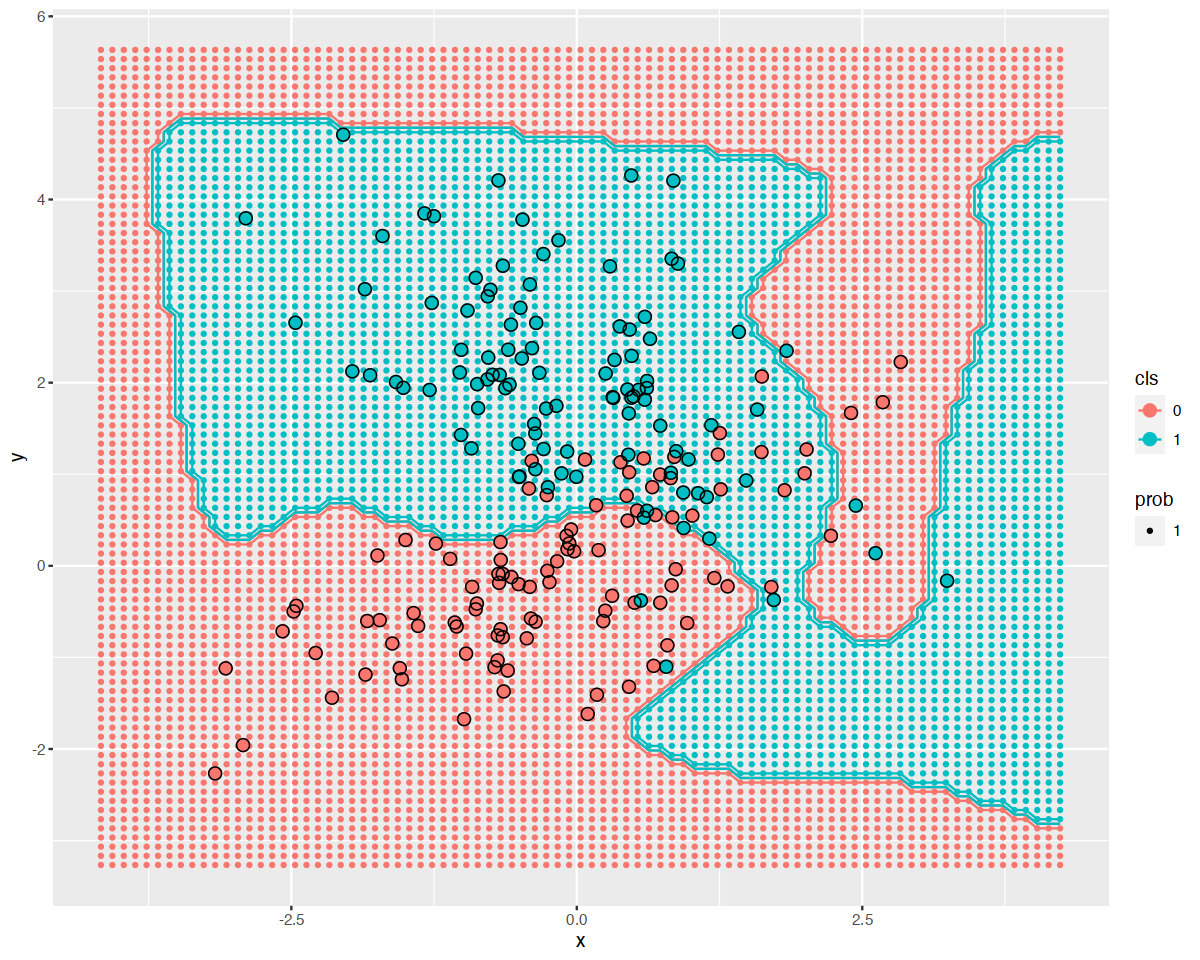

In [76]:
dataf <- bind_rows(mutate(test.grid,
                          prob=prob,
                          cls="1",
                          prob_cls=ifelse(classif==cls,
                                          1, 0)),
                   mutate(test.grid,
                          prob=prob,
                          cls="0",
                          prob_cls=ifelse(classif==cls,
                                          1, 0)))


ggplot(dataf) + 
  geom_point(aes(x=x, y=y, col=cls, size=prob),
             data = mutate(test.grid, cls=classif)) + 
  scale_size(range=c(0.1, 1)) +
  geom_contour(aes(x=x, y=y, z=prob_cls, group=cls, color=cls),
               bins=2,
               data=dataf) + geom_point(aes(x=x, y=y, col=cls),
             size=3,
             data=data.frame(x=train.data[,1], y=train.data[,2], cls=train.data$Y))  + 
  geom_point(aes(x=x, y=y),
             size=3, shape=1,
             data=data.frame(x=train.data[,1], y=train.data[,2], cls=train.data$Y))

## K Nearest neighbors

In [77]:
k =5

Train KNN

In [78]:
train <- X
cl <- factor(Y)

test <- expand.grid(x=seq(min(train[,1]-1), max(train[,1]+1),
                          by=0.1),
                    y=seq(min(train[,2]-1), max(train[,2]+1), 
                          by=0.1))

classif <- knn(train, test, cl, k = k, prob=TRUE)
prob <- attr(classif, "prob")

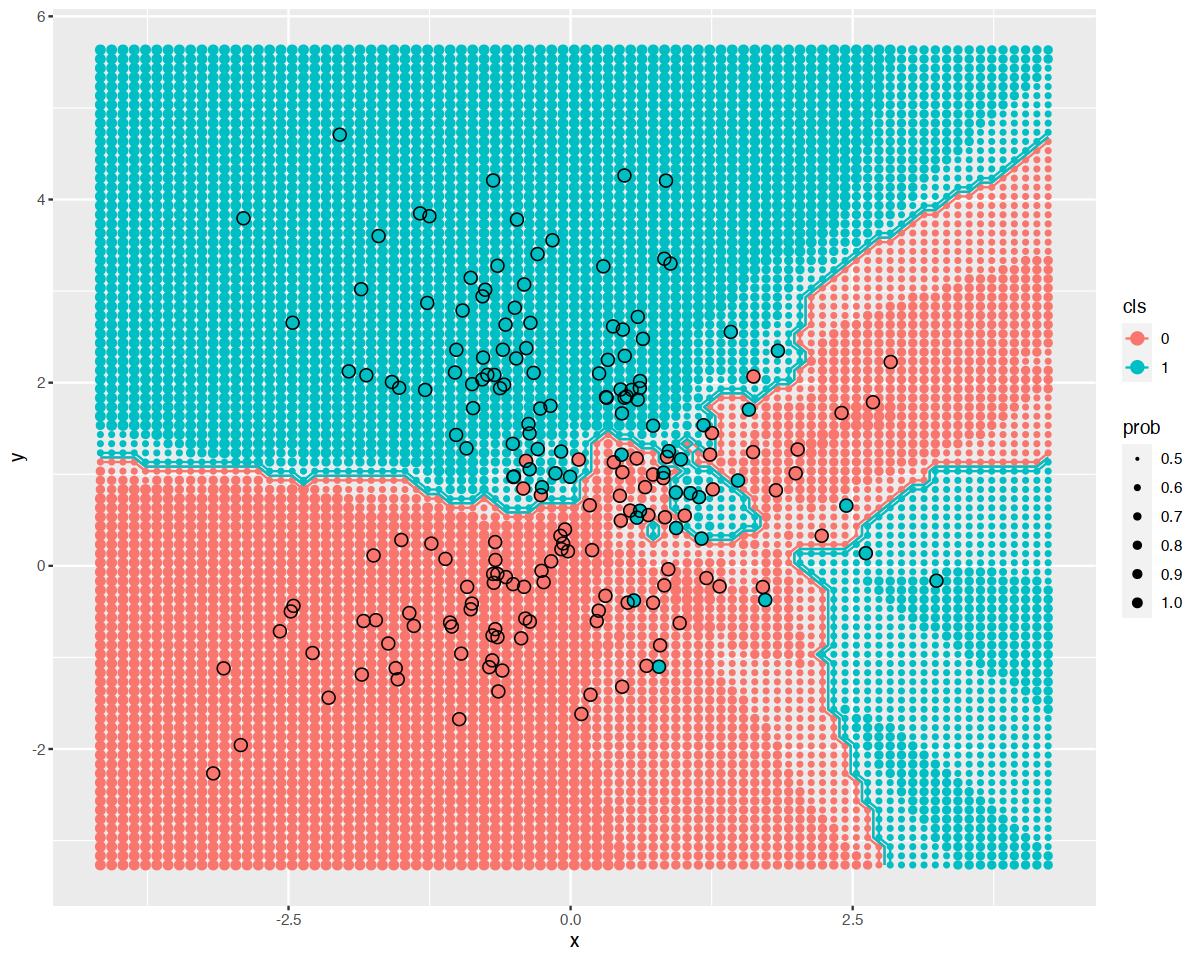

In [79]:
dataf <- bind_rows(mutate(test,
                          prob=prob,
                          cls="1",
                          prob_cls=ifelse(classif==cls,
                                          1, 0)),
                   mutate(test,
                          prob=prob,
                          cls="0",
                          prob_cls=ifelse(classif==cls,
                                          1, 0)))


ggplot(dataf) +
  geom_point(aes(x=x, y=y, col=cls, size=prob),
             data = mutate(test, cls=classif)) + 
  scale_size(range=c(0.1, 2)) +
  geom_contour(aes(x=x, y=y, z=prob_cls, group=cls, color=cls),
               bins=2,
               data=dataf) +
  geom_point(aes(x=x, y=y, col=cls),
             size=3,
             data=data.frame(x=train[,1], y=train[,2], cls=cl)) +
  geom_point(aes(x=x, y=y),
             size=3, shape=1,
             data=data.frame(x=train[,1], y=train[,2], cls=cl))
